# Summmary

<p>
This projects shows how a natural language processing algorithms can be used to determine emails as spam or not spam. This is a type of supervised learning. The data is a text corpus of emails either labeled as spam or not spam. The text in the labeled emails provides the features to classify an email as spam or not spam.
</p>

<p>
Email consists of course of text. The differentiation between spam or not spam is made on basis of the words written in the email text. Not every word of course works as a feature. Some stop words like “is” or “there” maybe given in both emails. Only special kind of words are associated with spam or not spam. The words are the key unit used in the analysis by the algorithm. 
</p>
  
<p>
Words cannot be parsed in efficient way by computers. The algorithms need numbers for successful parsing. Words are therefore transformed into vectors in higher dimensional spaces. The length and direction of those vectors determines the vectors and the similarities between different vectors supports the assumption of relationships. Before a vector can be created from a word it is necessary to segment the text into words in a process of tokenization. After transformation different kind of feature selection techniques like counting or other statistics to make the association between the label and the word occurrences. The predictions are evaluated and the results interpreted.
</p>

<p> </p>

<p>
<img src="textmining_process.jpg" alt="Smiley face" height="300" width="400"> 
</p>

# Import packages

In [442]:
# IPython
from IPython.display import display, HTML, display_html 
#usefull to display wide tables

# base packages
import numpy as np
import pandas as pd
import math
import random
import pathlib
import inspect
from datetime import datetime

# sklearn
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve


# pyspark
from pyspark.sql import DataFrame
from pyspark.rdd import RDD
from pyspark.sql.types import StructType, StructField, IntegerType, \
StringType, BooleanType, DateType, FloatType
from pyspark.sql.functions import lower, col
from pyspark.sql import SparkSession
from pyspark.rdd import RDD
from pyspark.sql.functions import mean, stddev , col, avg, round
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.functions import isnan


# machine learning in spark has got different libraries
# for different data objects

# machine learning on dataframes
# is based on pyspark.ml
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# machine learning on RDDs
# is based pyspark.mllib
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
# pyspark.mllib.classification.SVMModel
from pyspark.mllib.classification import SVMModel, SVMWithSGD
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Collaborative Filtering - RDD-based API
# https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pyspark_dist_explore import Histogram, hist, distplot, \
pandas_histogram

from handyspark import *

# Inspect working directory

In [443]:
cwd = os.getcwd()
print(cwd)

cwd_path = pathlib.Path.cwd()
# print(cwd_path)

home_path = pathlib.Path.home()
# print(home_path)

C:\Users\gamarandor\spark\spark-3.0.0-preview-bin-hadoop2.7\python\pyspark\projects\pyspark_class_spam


# Spark

### Spark context

In [444]:
print("Spark version: {}".format(sc.version))
print("Python version: {}".format(sc.pythonVer))
print("Spark master: {}".format(sc.master))
# print("Spark user: {}".format(sc.sparkUser))
print("Application name: {}".format(sc.appName))
# print("Application id: {}".format(sc.applicationId))
print("Parllelism: {}".format(sc.defaultParallelism))


Spark version: 3.0.0-preview
Python version: 3.7
Spark master: local[*]
Application name: PySparkShell
Parllelism: 4


### Spark session

<p>
<b>Spark Configuration</b><br>
from pyspark.sql import SparkSession<br>
spark = SparkSession.builder<br>
.appName("Python Spark regression example")<br>
.config("config.option", "value").getOrCreate()<br>
</p> 

### Spark session

In [445]:
# this is for example needed to activate the SQL-api
spark_session = SparkSession.builder.appName("spam_classification").\
getOrCreate()
print(spark_session)
print(spark_session.catalog.currentDatabase())
print(spark_session.catalog.listTables())

default
[]


# Import data

## Stop words

In [446]:
stopwords_pd = pd.read_table(r"english.txt")
print(type(stopwords_pd))
print(stopwords_pd.shape)

# to pd.Series
stop_pd_series = pd.Series(stopwords_pd.iloc[:,0])

stop_list = stop_pd_series.tolist()
print(type(stop_list))
print(len(stop_list))

<class 'pandas.core.frame.DataFrame'>
(1297, 1)
<class 'list'>
1297


## Spam data

In [447]:
spam = sc.textFile("spam.txt")

Filtering stopwords out.

In [448]:
spam = spam.filter(lambda x: x not in stop_list)

### Explore data

In [449]:
print(type(spam))

<class 'pyspark.rdd.PipelinedRDD'>


In [450]:
print(spam.count())

747


In [451]:
print(spam.first())

You have 1 new message. Please call 08712400200.


In [452]:
print(spam.take(3))

['You have 1 new message. Please call 08712400200.', 'Urgent! Please call 09061743811 from landline. Your ABTA complimentary 4* Tenerife Holiday or Â£5000 cash await collection SAE T&Cs Box 326 CW25WX 150ppm', "Dear 0776xxxxxxx U've been invited to XCHAT. This is our final attempt to contact u! Txt CHAT to 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 18yrs "]


## Tokenization

<p>is the first step in feature generation. A common definition of tokenization is made by <a href="https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html" target="_blank">nlp.stanford.edu </a></p> 


<p>
Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation. Here is an example of tokenization.
</p> 

<p>
Instead of using a dedicated tokenizer the lines are into words,
while keeping in mind that tokens are not necessarily words in general.
</p> 


In [453]:
spam_rdd = spam.flatMap(lambda lines: lines.split(" "))
print(spam_rdd.take(15))

['You', 'have', '1', 'new', 'message.', 'Please', 'call', '08712400200.', 'Urgent!', 'Please', 'call', '09061743811', 'from', 'landline.', 'Your']


Creating key-value-pairs from the RDD.

In [454]:
spam_mapped = spam_rdd.map(lambda x: (x,1))
print(type(spam_mapped))
print(spam_mapped.take(3))
    

<class 'pyspark.rdd.PipelinedRDD'>
[('You', 1), ('have', 1), ('1', 1)]


In [455]:
spam_grouped = spam_mapped.groupByKey()
print(type(spam_grouped))
print(spam_grouped.take(2))

<class 'pyspark.rdd.PipelinedRDD'>
[('have', <pyspark.resultiterable.ResultIterable object at 0x0000018658972E88>), ('1', <pyspark.resultiterable.ResultIterable object at 0x0000018658972588>)]


In [456]:
print(list((i[0], list(i[1])) for i in spam_grouped.take(5))[:1])

[('have', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]


In [457]:
spam_distinct = spam_rdd.distinct()

print(type(spam_distinct))
print(spam_distinct.take(5))
print(spam.count(), spam_distinct.count())

# the count of all observations as lines is 747
# the count of unique observations as words is 4324

<class 'pyspark.rdd.PipelinedRDD'>
['have', '1', 'new', 'Please', 'call']
747 4324


In [458]:
spam_cbv = spam_rdd.countByValue()

print(type(spam_cbv))
print(list(spam_cbv.items())[:10])

<class 'collections.defaultdict'>
[('You', 77), ('have', 128), ('1', 30), ('new', 42), ('message.', 5), ('Please', 34), ('call', 185), ('08712400200.', 1), ('Urgent!', 11), ('09061743811', 1)]


<p>
Top ten most frequent words with the sorted function.
</p> 
<p>
The sorted() function sorts the elements of a given iterable in a specific order (either ascending or descending).
</p> 
<p>
The syntax of sorted() is:
</p>
sorted(iterable, key=None, reverse=False)

In [459]:
spam_words_sorted = \
sorted(spam_cbv.items(), key=lambda x:x[1], reverse=True)

print(type(spam_words_sorted))
print(spam_words_sorted[:10])


<class 'list'>
[('to', 607), ('a', 360), ('your', 187), ('call', 185), ('or', 185), ('the', 178), ('2', 169), ('for', 169), ('you', 164), ('is', 143)]


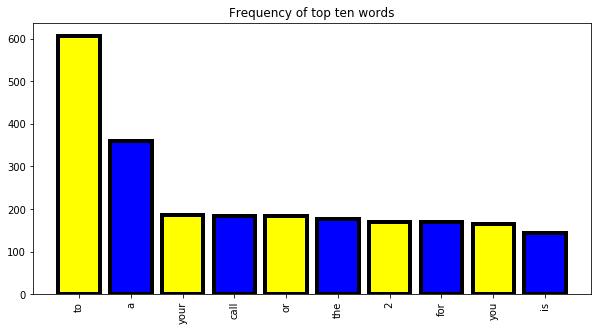

In [460]:
# turn list of tuples into a dict
spam_words_ten = dict(spam_words_sorted[:10])

plt.figure(figsize=(10,5))
plt.bar(range(len(spam_words_ten)), 
        list(spam_words_ten.values()), align='center', 
        edgecolor="black", linewidth=4, 
        color=['yellow', 'blue'])
plt.xticks(range(len(spam_words_ten)), 
           list(spam_words_ten.keys()), rotation=90)
plt.title("Frequency of top ten words")

plt.show()

## Non-spam data

In [461]:
nonespam = sc.textFile("ham.txt")

Filtering stopwords out.

In [462]:
nonespam = nonespam.filter(lambda x: x not in stop_list)

print(type(nonespam))
print(nonespam.take(3))

<class 'pyspark.rdd.PipelinedRDD'>
['Rofl. Its true to its name', "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free", 'Pity, * was in mood for that. So...any other suggestions?']


### Explore data

In [463]:
print(type(nonespam))

<class 'pyspark.rdd.PipelinedRDD'>


In [464]:
print(nonespam.count())

4827


In [465]:
print(nonespam.first())

Rofl. Its true to its name


In [466]:
print(nonespam.take(3))

['Rofl. Its true to its name', "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free", 'Pity, * was in mood for that. So...any other suggestions?']


## Tokenization


In [467]:
nonespam_rdd = nonespam.flatMap(lambda lines: lines.split(" "))
print(nonespam_rdd.take(15))

['Rofl.', 'Its', 'true', 'to', 'its', 'name', 'The', 'guy', 'did', 'some', 'bitching', 'but', 'I', 'acted', 'like']


Creating key-value-pairs from the RDD.

In [468]:
nonespam_mapped = nonespam_rdd.map(lambda x: (x,1))
print(type(nonespam_mapped))
print(nonespam_mapped.take(3))
    

<class 'pyspark.rdd.PipelinedRDD'>
[('Rofl.', 1), ('Its', 1), ('true', 1)]


In [469]:
nonespam_grouped = nonespam_mapped.groupByKey()
print(type(nonespam_grouped))
print(nonespam_grouped.take(2))

<class 'pyspark.rdd.PipelinedRDD'>
[('Rofl.', <pyspark.resultiterable.ResultIterable object at 0x0000018659F09EC8>), ('Its', <pyspark.resultiterable.ResultIterable object at 0x0000018659F09AC8>)]


In [470]:
print(list((i[0], list(i[1])) for i in nonespam_grouped.take(5))[:1])

[('Rofl.', [1])]


In [471]:
nonespam_distinct = nonespam_rdd.distinct()

print(type(nonespam_distinct))
print(nonespam_distinct.take(5))
print(nonespam.count(), nonespam_distinct.count())

# the count of all observations as lines is 747
# the count of unique observations as words is 4324

<class 'pyspark.rdd.PipelinedRDD'>
['Rofl.', 'Its', 'true', 'name', 'The']
4827 12623


In [472]:
nonespam_cbv = nonespam_rdd.countByValue()

print(type(nonespam_cbv))
print(list(nonespam_cbv.items())[:10])

<class 'collections.defaultdict'>
[('Rofl.', 1), ('Its', 68), ('true', 9), ('to', 1538), ('its', 125), ('name', 23), ('The', 73), ('guy', 22), ('did', 60), ('some', 108)]


In [473]:
nonespam_words_sorted = \
sorted(nonespam_cbv.items(), key=lambda x:x[1], reverse=True)

print(type(nonespam_words_sorted))
print(nonespam_words_sorted[:10])


<class 'list'>
[('to', 1538), ('you', 1462), ('I', 1439), ('the', 1029), ('a', 977), ('i', 742), ('and', 739), ('in', 736), ('u', 651), ('is', 645)]


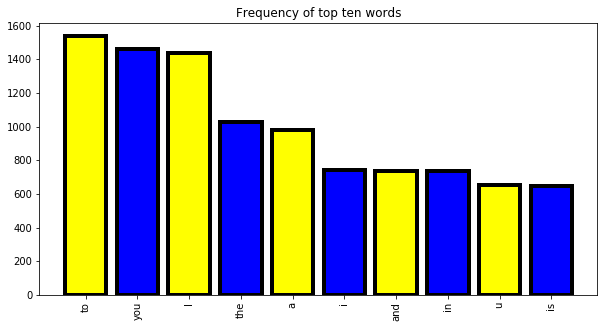

In [474]:
# turn list of tuples into a dict
nonespam_words_ten = dict(nonespam_words_sorted[:10])

plt.figure(figsize=(10,5))
plt.bar(range(len(nonespam_words_ten)), 
        list(nonespam_words_ten.values()), align='center', 
        edgecolor="black", linewidth=4, 
        color=['yellow', 'blue'])
plt.xticks(range(len(nonespam_words_ten)), 
           list(nonespam_words_ten.keys()), rotation=90)
plt.title("Frequency of top ten words")

plt.show()

# Machine Learning on text data to build a spam classifier


## Feature generation

<p>
The second step of the feature generation beginns here 
by creating an instance of a term frequency–inverse document frequency 
(TFIDF). An alternative popular method of vectorization is the 
"bag of words" method. According to
<a href="https://www.w3schools.com" target="_blank">Wikipedia</a> 
a TFIDF,
</p> 

<p>
"is  a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general."
</p>

<p>
The TFIDF creates 290 text vectors. A vector serves as a feature in the machine learning model. Apache offers a range of methods for <a href="https://spark.apache.org/docs/latest/ml-features.html" target="_blank">extracting, transforming and selecting features</a>.
</p> 




In [475]:
# from pyspark.mllib.feature import HashingTF
# keep in mind the difference between the mllib library for RDDs
# and ml-library for data frames

TFIDF_instance = HashingTF(numFeatures=290)
print(TFIDF_instance)

In [476]:
nonspam_vectors = TFIDF_instance.transform(nonespam_rdd)
print(type(nonspam_vectors))
print(nonspam_vectors.take(3))

<class 'pyspark.rdd.PipelinedRDD'>
[SparseVector(290, {3: 1.0, 86: 1.0, 202: 1.0, 213: 1.0, 252: 1.0}), SparseVector(290, {23: 1.0, 164: 1.0, 203: 1.0}), SparseVector(290, {23: 1.0, 31: 1.0, 114: 1.0, 173: 1.0})]


In [477]:
spam_vectors = TFIDF_instance.transform(spam_rdd)
print(type(spam_vectors))
print(spam_vectors.take(3))
print(spam_vectors.count())

<class 'pyspark.rdd.PipelinedRDD'>
[SparseVector(290, {29: 1.0, 31: 1.0, 213: 1.0}), SparseVector(290, {139: 1.0, 173: 1.0, 184: 1.0, 199: 1.0}), SparseVector(290, {72: 1.0})]
17893


<p>
The TFIDF transformation produces sparse vectors. 
Sparse vector are more efficient than dense vectors containing only nonzero values with indices.
The <a href="https://spark.apache.org/docs/latest/ml-features.html#tf-idf" target="_blank">doc</a> 
explains it this way.
</p>

<p>
The"below vector means there are 10 elements in the space. 
This set contains elem 2, elem 3 and elem 5. All non-zero values are treated as binary “1” values."
The zero values are "absent". This makes it sparse.
</p>

In [478]:
Vectors.sparse(10, {2:1.0, 3: 1.0, 5: 1.0})

SparseVector(10, {2: 1.0, 3: 1.0, 5: 1.0})

#### public class LabeledPoint

<p>
Taken from the documentations:
</p> 

<p>
Class that represents the features and labels of a data point.<br> 
param: label Label for this data point.<br> 
param: features List of features for this data point.<br> 
LabeledPoint(double label, Vector features)
</p>

<p>
A labeled point is a local vector, either dense or sparse, associated with a label/response. In MLlib, labeled points are used in supervised learning algorithms. We use a double to store a label, so we can use labeled points in both regression and classification. For binary classification, a label should be either 0 (negative) or 1 (positive). For multiclass classification, labels should be class indices starting from zero: 0, 1, 2, ....
</p>


<a href="https://spark.apache.org/docs/2.2.0/mllib-data-types.html" target="_blank">Labeled point</a> 


In [479]:
spam_labelpoints = \
spam_vectors.map(lambda vector_features:LabeledPoint(1,  vector_features))
# LabeledPoint(double label, Vector features)
# label = 1

print(type(spam_labelpoints))
print(spam_labelpoints.take(2))
print(spam_labelpoints.count())

<class 'pyspark.rdd.PipelinedRDD'>
[LabeledPoint(1.0, (290,[29,31,213],[1.0,1.0,1.0])), LabeledPoint(1.0, (290,[139,173,184,199],[1.0,1.0,1.0,1.0]))]
17893


Every vector of spam_vectors is labeled with a 1.

In [480]:
nonspam_labelpoints = \
nonspam_vectors.map(lambda  vector_features: LabeledPoint(0, 
                                                          vector_features))


print(type(nonspam_labelpoints))
print(nonspam_labelpoints.take(2))
print(nonspam_labelpoints.count())

<class 'pyspark.rdd.PipelinedRDD'>
[LabeledPoint(0.0, (290,[3,86,202,213,252],[1.0,1.0,1.0,1.0,1.0])), LabeledPoint(0.0, (290,[23,164,203],[1.0,1.0,1.0]))]
69642


Every vector of nonspam_vectors is labeled with a 0.

union(other)

Return a new DataFrame containing union of rows in this frame and another frame.
This is equivalent to UNION ALL in SQL. To do a SQL-style set union (that does deduplication of elements), use this function followed by a distinct.

<a href="https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html" target="_blank">pyspark.sql module</a> 

In [481]:
combined = spam_labelpoints.union(nonspam_labelpoints)

print(type(combined))

print(combined.count())

print(spam_labelpoints.count() + nonspam_labelpoints.count())

print(combined.take(2))

<class 'pyspark.rdd.RDD'>
87535
87535
[LabeledPoint(1.0, (290,[29,31,213],[1.0,1.0,1.0])), LabeledPoint(1.0, (290,[139,173,184,199],[1.0,1.0,1.0,1.0]))]


### Train-test-split

In [482]:
training, testing = combined.randomSplit([0.8, 0.2])

In [483]:
print(training.take(3))
print(training.count())
print(testing.take(3))
print(testing.count())

[LabeledPoint(1.0, (290,[29,31,213],[1.0,1.0,1.0])), LabeledPoint(1.0, (290,[139,173,184,199],[1.0,1.0,1.0,1.0])), LabeledPoint(1.0, (290,[72],[1.0]))]
70046
[LabeledPoint(1.0, (290,[91,139,158,164,173,202],[1.0,1.0,1.0,2.0,2.0,1.0])), LabeledPoint(1.0, (290,[27,86,139,164,173],[1.0,1.0,1.0,1.0,2.0])), LabeledPoint(1.0, (290,[23,63,86,173,176,213,224],[1.0,1.0,2.0,1.0,2.0,2.0,1.0]))]
17489


Extract the labels: spam 1 or not spam 2.

In [484]:
labels_1 = training.map(lambda x: x.label)
print(type(labels_1))
print(labels_1.take(10))
print(labels_1.countByValue())

<class 'pyspark.rdd.PipelinedRDD'>
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
defaultdict(<class 'int'>, {1.0: 14312, 0.0: 55734})


In [485]:
labels_2 = testing.map(lambda x: x.label)
print(type(labels_2))
print(labels_2.take(25))
print(labels_2.countByValue())

<class 'pyspark.rdd.PipelinedRDD'>
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
defaultdict(<class 'int'>, {1.0: 3581, 0.0: 13908})


### Build the LogisticRegressionWithLBFGS model

In [486]:
log_model = LogisticRegressionWithLBFGS.train(training)

### Make predictions

In [487]:
log_preds = log_model.predict(testing.map(lambda x: x.features))

print(type(log_preds))
print(log_preds.take(20))
print("testing observations {}".format(labels_2.countByValue()))
print("predicted values {}".format(log_preds.countByValue()))
print(log_preds.count())

<class 'pyspark.rdd.PipelinedRDD'>
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
testing observations defaultdict(<class 'int'>, {1.0: 3581, 0.0: 13908})
predicted values defaultdict(<class 'int'>, {0: 16113, 1: 1376})
17489


Binding predictions and observations of the testing data together into
one RDD.

In [488]:
pred_labs = labels_2.zip(log_preds)
print(type(pred_labs))
print(pred_labs.take(5))

<class 'pyspark.rdd.RDD'>
[(1.0, 0), (1.0, 0), (1.0, 0), (1.0, 1), (1.0, 0)]


First element first tuple: observation 1 <br>
Second element first tuple: prediction 1 <br>
First element second tuple: observation 1 <br>
Second element second tuple: prediction 0

### Evaluation in Pyspark

#### Accuracy

True or False predictions of observations.

In [489]:
log_pred_true_false = \
pred_labs.map(lambda x: x[0] == x[1])

print(type(log_pred_true_false))
print(log_pred_true_false.take(10))

<class 'pyspark.rdd.PipelinedRDD'>
[False, False, False, True, False, False, False, False, False, True]


Extracting only true predictions by filtering out the false predictions.

In [490]:
log_pred_true = \
pred_labs.filter(lambda x: x[0]==x[1])

print(type(log_pred_true))
print(log_pred_true.take(10))

<class 'pyspark.rdd.PipelinedRDD'>
[(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1)]


How many predictions were correct?

In [491]:
log_acc_count = log_pred_true.count()

print(type(log_acc_count))
print(log_acc_count)
print(testing.count())
# 14258 of 17464 were correctly predicted

<class 'int'>
14268
17489


Proportion of correct predictions of all observations of the testing data set is called accuracy.

In [492]:
log_accuracy = log_acc_count / float(testing.count())
print(log_accuracy)

0.8158270913145406


Spam emails could be predicted with an accuracy of 81 percent.

Creating labels and predictions in one step.

In [493]:
log_pred_labels = \
testing.map(lambda lp: (float(log_model.predict(lp.features)), lp.label)) 
print(type(log_pred_labels))
print(log_pred_labels.take(10))

<class 'pyspark.rdd.PipelinedRDD'>
[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (1.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (1.0, 1.0)]


#### BinaryClassificationMetrics

In [494]:
# from pyspark.mllib.evaluation import BinaryClassificationMetrics
log_metrics = BinaryClassificationMetrics(log_pred_labels)

# Area under precision-recall curve
print("Area under PR = %s" % log_metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % log_metrics.areaUnderROC)


Area under PR = 0.46942163765196204
Area under ROC = 0.6029323265819017


### Evaluation in Pandas and SKlearn

Converting RDD to data frame

In [495]:
log_df = sqlContext.createDataFrame(log_pred_labels)

log_df.printSchema()
print(type(log_df))
print(log_df.show(5))

root
 |-- _1: double (nullable = true)
 |-- _2: double (nullable = true)

<class 'pyspark.sql.dataframe.DataFrame'>
+---+---+
| _1| _2|
+---+---+
|0.0|1.0|
|0.0|1.0|
|0.0|1.0|
|1.0|1.0|
|0.0|1.0|
+---+---+
only showing top 5 rows

None


Converting pyspark toPandas.

In [496]:
log_pd = log_df.toPandas()
print(log_pd.info())

log_pd.columns = ['predictions', 'labels']
log_pd.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17489 entries, 0 to 17488
Data columns (total 2 columns):
_1    17489 non-null float64
_2    17489 non-null float64
dtypes: float64(2)
memory usage: 273.4 KB
None


,predictions,labels
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,1.0,1.0
4,0.0,1.0


Pandas crosstab or confusion matrix

In [497]:
pd.crosstab(log_pd.labels,
            log_pd['predictions'])

predictions,0.0,1.0
labels,,
0.0,13400,508
1.0,2713,868


In [498]:
confusion_matrix(log_pd.labels, log_pd['predictions'])

array([[13400,   508],
       [ 2713,   868]], dtype=int64)

#### Classification report

In [499]:
precision_recall_fscore_support(log_pd.labels, log_pd['predictions'], 
                                average='macro')

(0.731220295182714, 0.6029323265819018, 0.6214601295467324, None)

In [500]:
print(classification_report(log_pd.labels, log_pd['predictions']))

              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89     13908
         1.0       0.63      0.24      0.35      3581

    accuracy                           0.82     17489
   macro avg       0.73      0.60      0.62     17489
weighted avg       0.79      0.82      0.78     17489



### Data visualization with Pyplot on the log-model


<p>
I did try to do the data visualization directly on the RDD with HandySpark, but this did not worked out. It seems that Handspark needs the data to be in the form of a VectorAssembler. Otherwise the function below does not work:
</p> 
<p>
bcm = BinaryClassificationMetrics(predictions, scoreCol='probability', labelCol='Survived')
</p> 


<a href="https://github.com/dvgodoy/handyspark" target="_blank">Wikipedia</a> 

<p>
As HandySpark does not worked I resorted to Pandas and Pyplot.
</p> 



In [501]:
# create Pyspark data frame from RDD
log_pd = sqlContext.createDataFrame(log_pred_labels, schema)

log_pd.printSchema()
print(type(log_pd))
print(log_pd.show(5))

root
 |-- predictions: float (nullable = true)
 |-- labels: float (nullable = true)

<class 'pyspark.sql.dataframe.DataFrame'>
+-----------+------+
|predictions|labels|
+-----------+------+
|        0.0|   1.0|
|        0.0|   1.0|
|        0.0|   1.0|
|        1.0|   1.0|
|        0.0|   1.0|
+-----------+------+
only showing top 5 rows

None


In [502]:
# convert pyspark data frame to pandas data frame
log_pandas = log_pd.toPandas()
log_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17489 entries, 0 to 17488
Data columns (total 2 columns):
predictions    17489 non-null float32
labels         17489 non-null float32
dtypes: float32(2)
memory usage: 136.8 KB


In [503]:
# import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr_log, tpr_log, threshold_log = \
metrics.roc_curve(log_pandas.predictions, 
                  log_pandas.labels)
roc_auc_log = metrics.auc(fpr, tpr)

print("thresholds: {}".format(threshold_log))
print("fpr - specificity: {}".format(fpr_log))
print("tpr - sensitivity, recall: {}".format(tpr_log))
print("roc_auc: {}".format(roc_auc_log))

thresholds: [2. 1. 0.]
fpr - specificity: [0.         0.16837336 1.        ]
tpr - sensitivity, recall: [0.         0.63081395 1.        ]
roc_auc: 0.7726528913382114


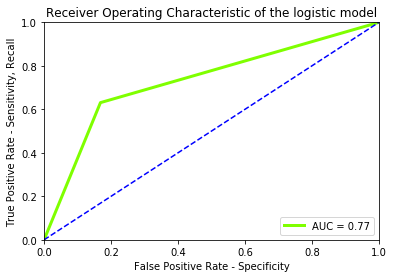

In [504]:
plt.title('Receiver Operating Characteristic of the logistic model')
plt.plot(fpr_log, tpr_log, 'chartreuse', 
         label = 'AUC = %0.2f' % roc_auc_log,
         linewidth=3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate - Sensitivity, Recall')
plt.xlabel('False Positive Rate - Specificity')
plt.show()


In [505]:
# from sklearn.metrics import precision_recall_curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

precision_log_sk, recall_log_sk, thresholds_log_sk = \
precision_recall_curve(log_pandas.predictions, log_pandas.labels)

print("precision: {}".format(precision_log_sk))
print("recall: {}".format(recall_log_sk))
print("thresholds: {}".format(thresholds_log_sk))


precision: [0.07867803 0.24239039 1.        ]
recall: [1.         0.63081395 0.        ]
thresholds: [0. 1.]


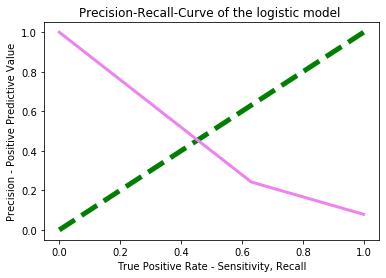

In [506]:
plt.title("Precision-Recall-Curve of the logistic model ")
plt.plot([0,1], [0,1], 'g--', linewidth=5)
plt.xlabel('True Positive Rate - Sensitivity, Recall')
plt.ylabel('Precision - Positive Predictive Value')
plt.plot(recall_log_sk, precision_log_sk, color="violet",
         linewidth = 3)
plt.show()

### Build the SVMWithSGD model

class pyspark.mllib.classification.SVMModel(weights, intercept)<br>
Model for Support Vector Machines (SVMs).<br>
Parameters<br>
weights – Weights computed for every feature.<br>
intercept – Intercept computed for this model.<br>

<a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html" target="_blank">
pyspark.mllib.classification module</a> 

In [507]:
svm = SVMWithSGD.train(training, iterations=10)
print(type(svm))


<class 'pyspark.mllib.classification.SVMModel'>


### Make predictions

In [508]:
svm_preds = svm.predict(testing.map(lambda x: x.features))

print(type(svm_preds))
print(svm_preds.take(15))
print(svm_preds.countByValue())

<class 'pyspark.rdd.PipelinedRDD'>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
defaultdict(<class 'int'>, {0: 17003, 1: 486})


Convert predictions to float.

In [509]:
svm_preds = svm_preds.map(lambda x: float(x))

print(type(svm_preds))
print(svm_preds.take(10))

<class 'pyspark.rdd.PipelinedRDD'>
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Making an RDD of labels (first element) and predictions (second element).

In [510]:
svmPreds_labelsTest = labels_2.zip(svm_preds)

print(type(svmPreds_labelsTest))
print(svmPreds_labelsTest.take(3))
print(svmPreds_labelsTest.countByValue())

<class 'pyspark.rdd.RDD'>
[(1.0, 0.0), (1.0, 0.0), (1.0, 0.0)]
defaultdict(<class 'int'>, {(1.0, 0.0): 3247, (1.0, 1.0): 334, (0.0, 0.0): 13756, (0.0, 1.0): 152})


Creating labels and predictions in one step.

In [511]:
predictionAndLabels_svm = \
testing.map(lambda lp: (float(svm.predict(lp.features)), float(lp.label))) 
print(type(predictionAndLabels))
print(predictionAndLabels.take(10))

<class 'pyspark.rdd.PipelinedRDD'>
[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]


### Evaluation wit Pyspark

#### Accuracy

In [512]:
svm_true_false = svmPreds_labelsTest.map(lambda x: x[0]==x[1])

print(type(svm_true_false))
print(svm_true_false.take(10) )


<class 'pyspark.rdd.PipelinedRDD'>
[False, False, False, False, False, False, False, False, False, False]


In [513]:
# only true predictions
svm_true = svmPreds_labelsTest.filter(lambda x: x[0]==x[1])

In [514]:
svm_true_count = svm_true.count()

In [515]:
svm_accuracy = (svm_true_count / testing.count())
print(svm_accuracy)

0.8056492652524444


The svm model produces a slightly lower accuracy.

#### BinaryClassificationMetrics

In [516]:
# from pyspark.mllib.evaluation import BinaryClassificationMetrics
binary_metrics = BinaryClassificationMetrics(predictionAndLabels_svm)

# Area under precision-recall curve
print("Area under PR = %s" % binary_metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % binary_metrics.areaUnderROC)


Area under PR = 0.4685007582706282
Area under ROC = 0.5411705372770375


### Evaluation in Pandas and SKlearn

Converting RDD to data frame

In [517]:
# Determine data types with schema
# This avoids conflicts
schema_svm = StructType([
StructField("predictions", FloatType(), True),
StructField("labels", FloatType(), True)])

In [518]:
svm_df = sqlContext.createDataFrame(predictionAndLabels, schema_svm)

svm_df.printSchema()
print(type(svm_df))
print(svm_df .show(5))

root
 |-- predictions: float (nullable = true)
 |-- labels: float (nullable = true)

<class 'pyspark.sql.dataframe.DataFrame'>
+-----------+------+
|predictions|labels|
+-----------+------+
|        0.0|   1.0|
|        0.0|   1.0|
|        0.0|   1.0|
|        0.0|   1.0|
|        0.0|   1.0|
+-----------+------+
only showing top 5 rows

None


Converting pyspark toPandas.

In [519]:
svm_pd = svm_df.toPandas()
print(svm_pd.info())

svm_pd.columns = ['predictions', 'labels']
svm_pd.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17623 entries, 0 to 17622
Data columns (total 2 columns):
predictions    17623 non-null float32
labels         17623 non-null float32
dtypes: float32(2)
memory usage: 137.8 KB
None


,predictions,labels
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


Pandas crosstab or confusion matrix

In [520]:
pd.crosstab(svm_pd.labels,
            svm_pd['predictions'])

predictions,0.0,1.0
labels,,
0.0,13931,127
1.0,3229,336


In [521]:
confusion_matrix(svm_pd.labels, svm_pd['predictions'])

array([[13931,   127],
       [ 3229,   336]], dtype=int64)

In [522]:
precision_svm = (365 /  (365 + 136))
print("precision: ", precision_svm)
# correctly determined (true) positives of all determined 
# as positives (FP, TP)

recall_svm = (365 / (365 + 3267))
# correctly determined (true) positives of all observed, labeled 
# positives or (TP, FN)
print("recall: ", recall_svm)

precision:  0.7285429141716567
recall:  0.10049559471365639


#### Classification report

In [523]:
precision_recall_fscore_support(svm_pd.labels, svm_pd['predictions'], 
                                average='macro')

(0.7687658903371646, 0.5426078236885578, 0.5296650463222304, None)

### Data visualization with Pyplot on the svm-model

In [524]:
# create Pyspark data frame from RDD
svm_df = sqlContext.createDataFrame(predictionAndLabels, schema)

svm_df.printSchema()
print(type(svm_df))
print(svm_df.show(5))

root
 |-- predictions: float (nullable = true)
 |-- labels: float (nullable = true)

<class 'pyspark.sql.dataframe.DataFrame'>
+-----------+------+
|predictions|labels|
+-----------+------+
|        0.0|   1.0|
|        0.0|   1.0|
|        0.0|   1.0|
|        0.0|   1.0|
|        0.0|   1.0|
+-----------+------+
only showing top 5 rows

None


In [525]:
# convert pyspark data frame to pandas data frame
svm_pandas = svm_df.toPandas()
svm_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17623 entries, 0 to 17622
Data columns (total 2 columns):
predictions    17623 non-null float32
labels         17623 non-null float32
dtypes: float32(2)
memory usage: 137.8 KB


In [526]:
# import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(svm_pandas.predictions, 
                                        svm_pandas.labels)
roc_auc = metrics.auc(fpr, tpr)

print("thresholds: {}".format(threshold))
print("fpr - specificity: {}".format(fpr))
print("tpr - sensitivity, recall: {}".format(tpr))
print("roc_auc: {}".format(roc_auc))

thresholds: [2. 1. 0.]
fpr - specificity: [0.         0.18817016 1.        ]
tpr - sensitivity, recall: [0.         0.72570194 1.        ]
roc_auc: 0.7687658903371648


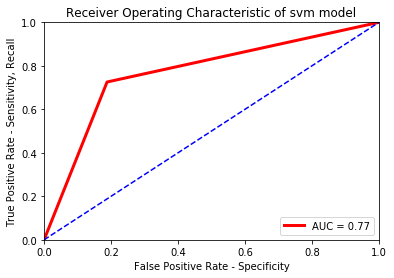

In [527]:
plt.title('Receiver Operating Characteristic of svm model')
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc,
         linewidth=3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate - Sensitivity, Recall')
plt.xlabel('False Positive Rate - Specificity')
plt.show()


In [528]:
# from sklearn.metrics import precision_recall_curve
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

precision_svm_sk, recall_svm_sk, thresholds_svm_sk = \
precision_recall_curve(svm_pandas.predictions, svm_pandas.labels)

print("precision: {}".format(precision_svm_sk))
print("recall: {}".format(recall_svm_sk))
print("thresholds: {}".format(thresholds_svm_sk))


precision: [0.02627248 0.09424965 1.        ]
recall: [1.         0.72570194 0.        ]
thresholds: [0. 1.]


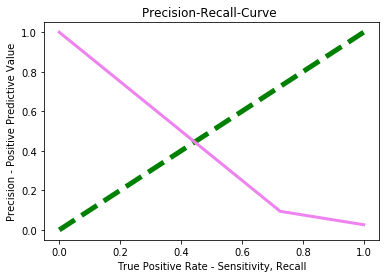

In [529]:
plt.title("Precision-Recall-Curve ")
plt.plot([0,1], [0,1], 'g--', linewidth=5)
plt.xlabel('True Positive Rate - Sensitivity, Recall')
plt.ylabel('Precision - Positive Predictive Value')
plt.plot(recall_svm_sk, precision_svm_sk, color="violet",
         linewidth = 3)
plt.show()